# 0. Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox
# Procesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVC
# Validación y Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# Métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# 1. Cargar Datos

In [2]:
# cargo el dataset
df_raw = pd.read_csv('../data_sample/amazon_best_sellers_2025_01_27.csv')

In [3]:
df_raw.shape

(25874, 30)

In [4]:
df_raw['price'] = df_raw['listedPrice'].combine_first(df_raw['salePrice']) # Combino listedPrice y salePrice, priorizando listedPrice para coger valores de salePrice solo cuando la primera sea nulo
print(f'shape post añadir columna: {df_raw.shape}') # Comprobación de que se añadio la columna
df_raw.drop(columns = ['listedPrice', 'salePrice'], inplace=True) # Elimino las columnas listedPrice y salePrice
print(f'shape post borrar columnas: {df_raw.shape}') # Comprobación de que se añadio la columna

shape post añadir columna: (25874, 31)
shape post borrar columnas: (25874, 29)


# Revisión y pruebas para entender dataset

In [5]:
# Reviso el DF a ver como están los datos

df_raw

,additionalProperties,brandName,breadcrumbs,color,currency,current_depth,description,descriptionRaw,features,gtin,...,scrapedDate,size,sku,style,url,variants,weight_rawUnit,weight_unit,weight_value,price
0,"[{""name"": ""mpaa rating"", ""value"": ""PG (Parenta...",NaN,"[{""name"": ""Movies & TV""}, {""name"": ""Featured C...",NaN,USD,1,"Amazon Exclusive 4K UHD + BD Steelbook, Amazon...",<article>\n\n<p>Amazon Exclusive 4K UHD + BD S...,NaN,NaN,...,2025-01-23T11:03:28Z,1 x 1 x 1 inches; 2.4 ounces,B0DTQCFGX3,NaN,https://www.amazon.com/dp/B0DTQCFGX3,NaN,NaN,NaN,NaN,44.99
1,"[{""name"": ""product dimensions"", ""value"": ""22 x...",Amazon Basics,"[{""name"": ""Pet Supplies""}, {""name"": ""Dogs""}, {...",Blue & White,USD,1,About this item\n\nINCLUDES: 100 Regular-size ...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""INCLUDES: 100 Regular-size standard-absorben...","[{""type"": ""gtin14"", ""value"": ""00841710108361""}]",...,2025-01-23T11:03:35Z,Regular (100 Count),B00MW8G62E,Regular,https://www.amazon.com/Amazon-Basics-Leak-Proo...,"[{""size"": ""Giant (40 Count)""}, {""size"": ""X-Lar...",Ounces,ounce,1.76,20.99
2,"[{""name"": ""brand"", ""value"": ""Alpha Grillers""},...",Alpha Grillers,"[{""name"": ""Home & Kitchen""}, {""name"": ""Kitchen...",Black/Red,USD,1,About this item\n\nInstant Read Food Thermomet...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""Instant Read Food Thermometer | Our instant ...","[{""type"": ""gtin14"", ""value"": ""00889121405136""}]",...,2025-01-23T11:03:38Z,NaN,B00S93EQUK,NaN,https://www.amazon.com/Thermometer-Cooking-BAC...,NaN,ounces,ounce,2.40,19.99
3,"[{""name"": ""asin"", ""value"": ""B0CW1FKFB9""}, {""na...",Rebecca Yarros,"[{""name"": ""Kindle Store""}, {""name"": ""Kindle eB...",NaN,USD,1,Rebecca Yarros is the #1 New York Times bestse...,<article>\n\n<p>Rebecca Yarros is the #1 New Y...,NaN,NaN,...,2025-01-23T11:03:42Z,4603 KB,B0CW1FKFB9,NaN,https://www.amazon.com/Onyx-Storm-Empyrean-Boo...,NaN,NaN,NaN,4603.00,29.99
4,"[{""name"": ""size"", ""value"": ""Medium (Pack of 10...",MED PRIDE,"[{""name"": ""Industrial & Scientific""}, {""name"":...",Iris Blue,USD,1,About this item\n\nNitrile\nImported\nThe idea...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""Nitrile"", ""Imported"", ""The ideal solution fo...",NaN,...,2025-01-23T11:03:51Z,Medium (Pack of 100),B00GS8W3T4,NaN,https://www.amazon.com/MedPride-Powder-Free-Ni...,"[{""size"": ""Small (pack of 100)""}, {""size"": ""Sm...",NaN,NaN,NaN,9.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25869,"[{""name"": ""product dimensions"", ""value"": ""2.28...",NaN,"[{""name"": ""Toys & Games""}, {""name"": ""Novelty &...",Earth,USD,4,Unlike other puzzle box toys that turn out dis...,<article>\n\n<ul><li> Unlike other puzzle box ...,"[""Unlike other puzzle box toys that turn out d...",NaN,...,2025-01-23T21:29:41Z,2.28 x 2.28 x 2.28 inches,B091M9N4FC,NaN,https://www.amazon.com/SHASHIBO-Shape-Shifting...,"[{""color"": ""Moon""}, {""color"": ""Undersea""}, {""c...",ounces,ounce,3.87,24.99
25870,"[{""name"": ""size"", ""value"": ""Large""}, {""name"": ...",BUNMO,"[{""name"": ""Toys & Games""}, {""name"": ""Novelty &...",NaN,USD,4,"Imaginative Creative Play - Pop, Crinkle, Pull...",<article>\n\n<ul><li> Imaginative Creative Pla...,"[""Imaginative Creative Play - Pop, Crinkle, Pu...","[{""type"": ""gtin13"", ""value"": ""5065003267015""}]",...,2025-01-23T21:29:43Z,Large,B07MBW6JNL,NaN,https://www.amazon.com/Pop-Tubes-Autism-Sensor...,"[{""size"": ""8""}, {""size"": ""30""}, {""size"": ""6""},...",ounces,ounce,1.12,11.75
25871,"[{""name"": ""item package dimensions l x w x h"",...",Champion Sports,"[{""name"": ""Toys & Games""}, {""name"": ""Sports & ...",Red (Single),USD,5,About this item\n\nSoft and bouncy nylon ball ...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""Soft and bouncy nylon ball versatile enough ...",NaN,...,2025-01-23T21:29:44Z,"5"" diameter",B003WYZ8DA,"5"" Diameter",h

In [6]:
df_raw.head()

,additionalProperties,brandName,breadcrumbs,color,currency,current_depth,description,descriptionRaw,features,gtin,...,scrapedDate,size,sku,style,url,variants,weight_rawUnit,weight_unit,weight_value,price
0,"[{""name"": ""mpaa rating"", ""value"": ""PG (Parenta...",NaN,"[{""name"": ""Movies & TV""}, {""name"": ""Featured C...",NaN,USD,1,"Amazon Exclusive 4K UHD + BD Steelbook, Amazon...",<article>\n\n<p>Amazon Exclusive 4K UHD + BD S...,NaN,NaN,...,2025-01-23T11:03:28Z,1 x 1 x 1 inches; 2.4 ounces,B0DTQCFGX3,NaN,https://www.amazon.com/dp/B0DTQCFGX3,NaN,NaN,NaN,NaN,44.99
1,"[{""name"": ""product dimensions"", ""value"": ""22 x...",Amazon Basics,"[{""name"": ""Pet Supplies""}, {""name"": ""Dogs""}, {...",Blue & White,USD,1,About this item\n\nINCLUDES: 100 Regular-size ...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""INCLUDES: 100 Regular-size standard-absorben...","[{""type"": ""gtin14"", ""value"": ""00841710108361""}]",...,2025-01-23T11:03:35Z,Regular (100 Count),B00MW8G62E,Regular,https://www.amazon.com/Amazon-Basics-Leak-Proo...,"[{""size"": ""Giant (40 Count)""}, {""size"": ""X-Lar...",Ounces,ounce,1.76,20.99
2,"[{""name"": ""brand"", ""value"": ""Alpha Grillers""},...",Alpha Grillers,"[{""name"": ""Home & Kitchen""}, {""name"": ""Kitchen...",Black/Red,USD,1,About this item\n\nInstant Read Food Thermomet...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""Instant Read Food Thermometer | Our instant ...","[{""type"": ""gtin14"", ""value"": ""00889121405136""}]",...,2025-01-23T11:03:38Z,NaN,B00S93EQUK,NaN,https://www.amazon.com/Thermometer-Cooking-BAC...,NaN,ounces,ounce,2.40,19.99
3,"[{""name"": ""asin"", ""value"": ""B0CW1FKFB9""}, {""na...",Rebecca Yarros,"[{""name"": ""Kindle Store""}, {""name"": ""Kindle eB...",NaN,USD,1,Rebecca Yarros is the #1 New York Times bestse...,<article>\n\n<p>Rebecca Yarros is the #1 New Y...,NaN,NaN,...,2025-01-23T11:03:42Z,4603 KB,B0CW1FKFB9,NaN,https://www.amazon.com/Onyx-Storm-Empyrean-Boo...,NaN,NaN,NaN,4603.00,29.99
4,"[{""name"": ""size"", ""value"": ""Medium (Pack of 10...",MED PRIDE,"[{""name"": ""Industrial & Scientific""}, {""name"":...",Iris Blue,USD,1,About this item\n\nNitrile\nImported\nThe idea...,<article>\n\n<h2>About this item</h2>\n\n<ul><...,"[""Nitrile"", ""Imported"", ""The ideal solution fo...",NaN,...,2025-01-23T11:03:51Z,Medium (Pack of 100),B00GS8W3T4,NaN,https://www.amazon.com/MedPride-Powder-Free-Ni...,"[{""size"": ""Small (pack of 100)""}, {""size"": ""Sm...",NaN,NaN,NaN,9.99


In [7]:
df_raw.shape # 25874, 30

(25874, 29)

In [8]:
columns = df_raw.columns.tolist()
columns

['additionalProperties',
 'brandName',
 'breadcrumbs',
 'color',
 'currency',
 'current_depth',
 'description',
 'descriptionRaw',
 'features',
 'gtin',
 'imageUrls',
 'inStock',
 'material',
 'mpn',
 'name',
 'new_path',
 'nodeName',
 'rating',
 'reviewCount',
 'scrapedDate',
 'size',
 'sku',
 'style',
 'url',
 'variants',
 'weight_rawUnit',
 'weight_unit',
 'weight_value',
 'price']

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25874 entries, 0 to 25873
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   additionalProperties  25829 non-null  object 
 1   brandName             23864 non-null  object 
 2   breadcrumbs           25671 non-null  object 
 3   color                 11265 non-null  object 
 4   currency              25251 non-null  object 
 5   current_depth         25874 non-null  int64  
 6   description           25868 non-null  object 
 7   descriptionRaw        25869 non-null  object 
 8   features              19213 non-null  object 
 9   gtin                  9223 non-null   object 
 10  imageUrls             25866 non-null  object 
 11  inStock               20952 non-null  object 
 12  material              10369 non-null  object 
 13  mpn                   12698 non-null  object 
 14  name                  25873 non-null  object 
 15  new_path           

In [10]:
# Revisar y definir columnas

# después de ver por encima las columnas tienen los datos un poco raros, voy a tratarlos para dejar el dataset limpio
# guardo el dataframe en excel para poder visualizar mejor los datos y ver como retocarlos
df_raw.to_excel("..\data_sample\learning_dataset\df_bs.xlsx", index=False)

Estas son las columnas, dejo esto aqui para completar con lo que define cada una

'additionalProperties',     caracteríticas de los productos desde un punto de vista más técnico
 'brandName',               nombre de la marca
 'breadcrumbs',             categorías del producto
 'color',                   colores de producto
 'currency',                moneda (todo está en USD)                       
 'current_depth',           categorías internas de Amazon
 'description',             descripción de los productos
 'descriptionRaw',          descripción de los productos raw (formato HTML)
 'features',                características de los productos de una forma más descriptiva
 'gtin',                    identificador global único del producto (Global Trade Item Number)
 'imageUrls',               url de las imágenes de los productos
 'inStock',                 indica si está en stock pero no la cantidad (TRUE hay, FALSE si no y hay columnas sin el dato)
 'listedPrice',             precio de cada producto
 'material',                material del que está hecho el producto
 'mpn',                     identificador del producto según el fabricante
 'name',                    nombre de cada producto
 'new_path',                indica la nueva categoría donde se encuentra el producto (categoría se refiere a donde se encuentra dentro del catálogo, si en Hogar, Accesorios, Electrodomesticos, etc...)
 'nodeName',                indica el nombre de la categoria (lo entiendo asi, pero en el dataset no hay diferencias entre las columnas)
 'rating',                  rating del producto (escala del 1 al 5, con saltos de 0.1)
 'reviewCount',             número de reviews
 'salePrice',               precio de oferta, aunque por lo que puedo ver, algunos productos solo tienen precio de oferta
 'scrapedDate',             fecha en la que se scrapeó la información
 'size',                    tamaño, con muchísima varización sobre la forma de reflejarlo
 'sku',                     es un código que Amazon utiliza para identificar el producto internamente
 'style',                   estilo del producto, tiene mucha variedad, no parece que haya categorías definidas y faltan muchos datos
 'url',                     url de los productos
 'variants',                son las opciones que tiene el producto (cuando te deja elegir modelo, tamaño, color, etc...)
 'weight_rawUnit',          unidad en la que va el peso (esta y la siguiente son en esencia lo mismo)
 'weight_unit',             unidad en la que va el peso (esta y la anterior son en esencia lo mismo)
 'weight_value'             peso del producto

 'additionalProperties', 'color', 'currency', 'current_depth', 'description', 'descriptionRaw', 'features', 'gtin', 'imageUrls', 'inStock', 'mpn', 'nodeName', 'scrapedDate', 'size', 'sku', 'style', 'url','weight_rawUnit'

 'new_path' (modificar, generalizar), 'listedPrice' y 'salePrice' (combinar), variants' (generalizar, ver si tiene), 'weight_unit', 'weight_value'

In [11]:
# comprobaciones para revisar columnas que no entiendo qué son con un vistazo a los resultados
# current_depth
# compruebo cuanto hay de cada categoria porque no termino de entender qué indica esta columna
values = df_raw['current_depth'].value_counts()
print(values)

nulls = df_raw['current_depth'].info()
print(df_raw.shape)
'''
current_depth
5     8494
4     7260
6     4314
3     2206
7     1728
8      890
9      395
2      311
10     239
1       37

Name: count, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 25874 entries, 0 to 25873
Series name: current_depth
Non-Null Count  Dtype
--------------  -----
25874 non-null  int64
dtypes: int64(1)
memory usage: 202.3 KB


(25874, 30)

'''

'''
RAZONAMIENTO PARA CURRENT_DEPTH
------------------------------------------------------------------------------------------------------------------------
Segun lo que pude encontrar, debería indicar 1 de 2 cosas, o una escala de categorías de Amazon,
o bien el número de clicks necesarios para llegar al producto (clicks a enlaces). Voy a contemplar esta columna como una escala de categorías de Amazon, si fuera el número de clicks
se me hace extraño que sea una escala definida del 1 al 10 si estuviera contando con cuantos clicks llega la gente, 10 me parecen bastantes clicks que hacer antes
de llegar al producto y si lo son, ¿por qué no contar los que fueran 11 o más? Entiendo que podría ser que solo sea relevante medir hasta 10, pero entonces se me hace raro
que no haya ningun producto que no tenga este dato, alguno que fueran mas de 10 clicks y que no estuviera clasificado, pero al no tener nulos la columna (indica que todos los productos
tienen una categoría) y teniendo en cuenta el hecho de que esto es una lista de productos más vendidos, no encuentro el sentido a reflejar los clicks, no parece que sea una media al ser 
una escala de enteros ordenados y me resulta muy extraño que un producto que de media tardas en encontrar 5/6+ clicks esté dentro de los mas vendidos, debería encontrarse más fácil.
''' 

current_depth
5     8494
4     7260
6     4314
3     2206
7     1728
8      890
9      395
2      311
10     239
1       37
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 25874 entries, 0 to 25873
Series name: current_depth
Non-Null Count  Dtype
--------------  -----
25874 non-null  int64
dtypes: int64(1)
memory usage: 202.3 KB
(25874, 29)


'\nRAZONAMIENTO PARA CURRENT_DEPTH\n------------------------------------------------------------------------------------------------------------------------\nSegun lo que pude encontrar, debería indicar 1 de 2 cosas, o una escala de categorías de Amazon,\no bien el número de clicks necesarios para llegar al producto (clicks a enlaces). Voy a contemplar esta columna como una escala de categorías de Amazon, si fuera el número de clicks\nse me hace extraño que sea una escala definida del 1 al 10 si estuviera contando con cuantos clicks llega la gente, 10 me parecen bastantes clicks que hacer antes\nde llegar al producto y si lo son, ¿por qué no contar los que fueran 11 o más? Entiendo que podría ser que solo sea relevante medir hasta 10, pero entonces se me hace raro\nque no haya ningun producto que no tenga este dato, alguno que fueran mas de 10 clicks y que no estuviera clasificado, pero al no tener nulos la columna (indica que todos los productos\ntienen una categoría) y teniendo en cu

In [12]:
#new_path, nodeName
comparacion = df_raw['new_path'] == df_raw['nodeName']
comparacion.value_counts()

# queria comprobar si ambas columnas eran iguales

True    25874
Name: count, dtype: int64

In [13]:
#weight_rawUnit, weight_unit
comparacion = df_raw['weight_rawUnit'] == df_raw['weight_unit']
comparacion.value_counts()

# visualmente parecian iguales, pero después de comprobarlo veo que no, la diferencia es que en weigh_rawUnit aparecen en plural

False    25873
True         1
Name: count, dtype: int64

In [14]:
''' analizo las columnas 1 a 1, saca la información del info un poco mas legible para mi, cuenta los valores unicos sin nulos y lo guarda
en un archivo para revisarlo mas facilmente '''

with open("../data_sample/learning_dataset/col_info.txt", "w", encoding="utf-8") as f:
    for col in columns:
        f.write(f'COLUMNA: {col.upper()}({col})')
        f.write('\n-------------------------------------------------------------------------------')
        f.write(f'\ndtype: {df_raw[col].dtype}\nnulls: {df_raw[col].isnull().sum()}\nvalores unicos: {df_raw[col].value_counts(dropna=True).sum()}')
        f.write('\n\n===============================================================================\n\n')

# 3. Dividir Train y Test

In [15]:
# Antes de dividir train y test, como el dataset tiene 2 columnas de precios y yo quiero definir una como target, voy a tratarlas para convertirlas en una nueva y usarla como target.
# Las columnas con precios son listedPrice (precio normal) y salePrice (precio de oferta).
# Quiero como target listedPrice. Como la columna contiene nulos, voy a unirla con salePrice solo para intentar cubrir alguno de esos nulos. Interpreto que donde no hay listedPrice es porque son productos
#   que entraron en los más vendidos vendiendo solo a través de ofertas, esto creo que convierte al precio de oferta en el precio real del producto y se puede pasar directamente a listedPrice.

# Aprovecho y elimino las filas con nulos en price ya que si no tengo el precio con esas columnas no puedo hacer nada.
df_raw = df_raw.dropna(subset = ['price'])

In [16]:
# reviso que no haya 0s
df_raw['price'].where(df_raw['price'] <= 0).value_counts() # no hay 0s

Series([], Name: count, dtype: int64)

In [17]:
# Hago el split de train y test, dejando un 30% para test

X_train, X_test, y_train, y_test = train_test_split(df_raw.drop('price', axis=1),
                                                    df_raw['price'],
                                                    test_size=0.3,
                                                    random_state=40)

In [18]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17675, 28)
(17675,)


<Axes: xlabel='price', ylabel='Density'>

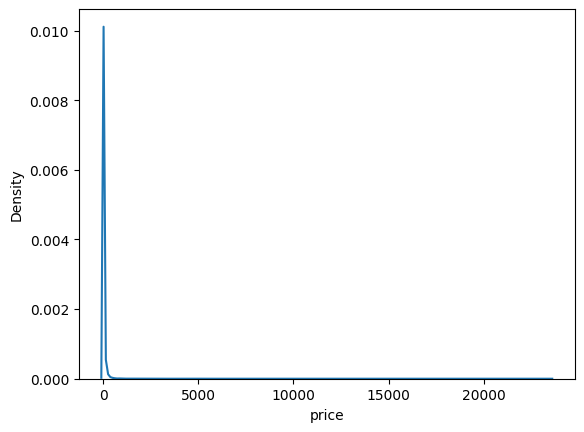

In [19]:
# distribucion de target
sns.kdeplot(y_train)

Text(0.5, 1.0, 'power2')

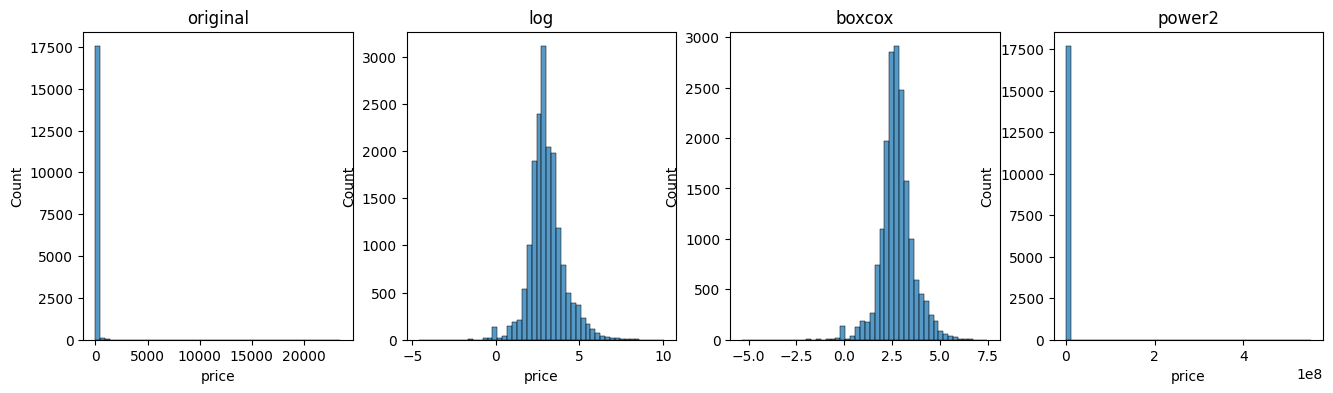

In [20]:
# reviso transformaciones

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(y_train, bins=50, ax=axes[0]).set_title("original")
sns.histplot(np.log(y_train), bins=50, ax=axes[1]).set_title("log")
sns.histplot(stats.boxcox(y_train)[0], bins=50, ax=axes[2]).set_title("boxcox")
sns.histplot(np.power(y_train, 2), bins=50, ax=axes[3]).set_title("power2")

In [21]:
log_y = np.log1p(y_train)          # log(1 + y) si hay ceros
boxcox_y, lam = stats.boxcox(y_train)  # y debe ser > 0


for name, values in {'orig':y_train, 'log':log_y, 'boxcox':boxcox_y}.items():
    sample = values if len(values) <= 5000 else np.random.choice(values, 4999, replace=False) # limito a 5000 muestras para evitar warning de saphiro
    print(f'\n{name.upper()}')
    print(' skew =', stats.skew(values))
    print(' kurt =', stats.kurtosis(values, fisher=True))
    print(' Shapiro p =', stats.shapiro(sample).pvalue)


ORIG
 skew = 65.59604393088034
 kurt = 6042.232834749758
 Shapiro p = 1.7160891129117248e-90

LOG
 skew = 0.8112556634746558
 kurt = 2.38618039433054
 Shapiro p = 4.758039073474389e-38

BOXCOX
 skew = -0.06444516558641568
 kurt = 3.33985956091532
 Shapiro p = 2.5346863592555346e-33


In [22]:
# Aplico la transformacion y guardo el lambda
y_train_boxcox, mi_lambda = stats.boxcox(y_train)

print(f'lambda usado para transformar despues: {mi_lambda}') # -0.06186567113028077

lambda usado para transformar despues: -0.06186567113028077


In [23]:
# aplico la transformacion a test
y_test_boxcox = stats.boxcox(y_test, mi_lambda)

In [24]:
y_train_boxcox

array([3.14345841, 3.06584195, 3.27785279, ..., 1.95014164, 2.14523249,
       2.14523249], shape=(17675,))

In [25]:
y_train = y_train_boxcox
y_test = y_test_boxcox

In [26]:
y_train

array([3.14345841, 3.06584195, 3.27785279, ..., 1.95014164, 2.14523249,
       2.14523249], shape=(17675,))

In [27]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17675, 28)
(17675,)


# 6. Feature Reduction Preliminar

In [28]:
drop_columns = ['additionalProperties', 'color', 'features', 'size', 'style', 'weight_unit', 'weight_value', 'material', 'currency', 'current_depth', 'gtin', 'mpn', 'scrapedDate', 'sku', 'url',
                'description', 'descriptionRaw', 'imageUrls', 'inStock', 'nodeName', 'weight_rawUnit', 'breadcrumbs', 'name']


X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

In [29]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17675, 5)
(17675,)


In [30]:
X_train.columns

Index(['brandName', 'new_path', 'rating', 'reviewCount', 'variants'], dtype='object')

In [31]:
X_test.columns

Index(['brandName', 'new_path', 'rating', 'reviewCount', 'variants'], dtype='object')

In [32]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17675, 5)
(17675,)


In [33]:
isinstance(y_train, pd.Series) 

False

# 7. Feature Engineering

In [34]:
X_train['brand'] = X_train['brandName']
X_test['brand'] = X_test['brandName']

# Elimina 'Brand:' de algunas de las marcas
X_train['brand'] = X_train['brandName'].str.replace(r'(?i)^.*brand:\s*', '', regex=True).str.strip()
X_test['brand'] = X_test['brandName'].str.replace(r'(?i)^.*brand:\s*', '', regex=True).str.strip()

# Algunos valores son números, por lo que elimino los números
# Hago una máscara para ver cuáles son numéricos
mask_numeric = pd.to_numeric(X_train['brand'], errors='coerce').notna()

# Convierto a series y_train para poder tener un indice con el que borrar las mismas filas de X en Y
y_train = pd.Series(y_train, index=X_train.index)
index_mask = X_train[mask_numeric].index # guardo la máscara en una variable para que no haya problemas cuando dropee de Y por haber dropeado antes en X

# Elimino las filas con numéricos
X_train.drop(index=index_mask, inplace=True)
y_train.drop(index=index_mask, inplace=True)

In [35]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17646, 6)
(17646,)


In [36]:
# Quiero hacer agrupaciones de marcas para tener menos categorias y poder utilizar la columna, hay varios de Amazon que voy a agrupar en una sola categoria
X_train['brand'] = X_train['brand'].str.lower() # lo paso a minusculas para evitar diferencias Aa
X_test['brand'] = X_test['brand'].str.lower() # lo paso a minusculas para evitar diferencias Aa

X_train['brand'] = X_train['brand'].str.replace(r'.*amazon.*', 'Amazon', regex = True)
X_test['brand'] = X_test['brand'].str.replace(r'.*amazon.*', 'Amazon', regex = True)


In [37]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17646, 6)
(17646,)


In [38]:
# Hago una copia para hacer pruebas mas cómodo
df_pruebas_train = X_train.copy()

valcount = df_pruebas_train.brand.value_counts()

top99 = valcount.head(99).index.to_list()

df_pruebas_train['brand'] = df_pruebas_train['brand'].where(df_pruebas_train['brand'].isin(top99), other = 'Other')



In [39]:
valcount = df_pruebas_train.brand.value_counts()
valcount

brand
Other             15481
.us                 782
Amazon              168
audible logo        122
generic              99
                  ...  
d'addario             6
bosch                 6
evil energy           6
bob's red mill        6
wilson                6
Name: count, Length: 100, dtype: int64

In [40]:
df_pruebas_train.brand.shape

(17646,)

In [41]:
# parece que otros es la mayoria del data set, voy a ver si puedo dividirlo mas
# para el volumen de datos que es, aunque la visualización va a ser compleja, creo que puedo dejarlo sobre 100 categorias
# ahora mismo ya tengo 100, teniendo 15482 marcas en otros de 17647, voy a ver si dividiendo Otros en 40 categorias consigo dividir mejor los datos
# primero vuelvo a hacer lo de antes para ver cuantos datos tendria que dividir entre las 40 categorias
df_pruebas_train = X_train.copy()

valcount = df_pruebas_train.brand.value_counts()

top99 = valcount.head(60).index.to_list()

df_pruebas_train['brand'] = df_pruebas_train['brand'].where(df_pruebas_train['brand'].isin(top99), other = 'Other')

In [42]:
valcount = df_pruebas_train.brand.value_counts()
valcount

brand
Other                   15740
.us                       782
Amazon                    168
audible logo              122
generic                    99
                        ...  
mr. pen                     8
edelbrock                   8
stanley                     8
best choice products        7
permatex                    7
Name: count, Length: 61, dtype: int64

In [43]:
df_pruebas_train.brand.shape

(17646,)

In [44]:
# aqui veo las 60 mas representadas, con esto veo que dividir other en 40 categorias no tiene sentido, la frencuencia con la que aparecen es la única cosa bajo las que agruparlas a priori y no puedo hacer
# 40 argupaciones en base a eso
'''
df_pruebas_train = X_train.copy()

valcount = df_pruebas_train.brand.value_counts()

top60 = valcount.head(60)

top99
'''

# Voy a probar otra forma de dividir, voy a quedarme con todas las marcas que aparezcan minimo 7 veces

df_pruebas_train = X_train.copy()

valcount = df_pruebas_train['brand'].value_counts()

brands_7 = valcount[valcount >= 7].index # sacar las que aparecen 7 veces o mas

df_pruebas_train = df_pruebas_train[df_pruebas_train['brand'].isin(brands_7)]

df_pruebas_train['brand'].value_counts()



brand
.us               782
Amazon            168
audible logo      122
generic            99
vevor              41
                 ... 
fiskars             7
rebecca yarros      7
3m                  7
permatex            7
utopia home         7
Name: count, Length: 85, dtype: int64

In [45]:
df_pruebas_train.brand.value_counts().sum()

np.int64(2081)

In [46]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17646, 6)
(17646,)


In [47]:
'''
esto era para ver cuantas categorias tendria dividiendo por frecuencia

brand_freq = df_pruebas_train['brand'].value_counts()


freq_of_freq = brand_freq.value_counts().sort_index()

print(freq_of_freq)

num_categorias = freq_of_freq.index.nunique()

print(num_categorias)

'''

"\nesto era para ver cuantas categorias tendria dividiendo por frecuencia\n\nbrand_freq = df_pruebas_train['brand'].value_counts()\n\n\nfreq_of_freq = brand_freq.value_counts().sort_index()\n\nprint(freq_of_freq)\n\nnum_categorias = freq_of_freq.index.nunique()\n\nprint(num_categorias)\n\n"

In [48]:
# quedan 28 categorias, pero voy a dividir cat1 (la que agrupa las marcas con frecuencia 1) segun categoria, a ver si puedo dividirlo mas, hay 38 categorias asi que aunque añada 38 divisiones mas,
# no acabaría con demasiadas categorías

# primero trato la columna new_path para usarla como cateogira

# Creo una columna nueva cogiendo el valor hasta el primer >, quedandose con la primera parte y con todo si no encuentra nada
X_train['category'] = X_train['new_path'].str.split(">").str[0].str.strip()
X_test['category'] = X_test['new_path'].str.split(">").str[0].str.strip()  
df_pruebas_train['category'] = df_pruebas_train['new_path'].str.split(">").str[0].str.strip() 

# Veo la diferencia de categorías
print(f"Número de categorías de new_path: {X_train['new_path'].nunique()}")
print(f"Número de categorías de category: {X_train['category'].nunique()}")

print(f"Número de categorías de new_path: {df_pruebas_train['new_path'].nunique()}")
print(f"Número de categorías de category: {df_pruebas_train['category'].nunique()}")

Número de categorías de new_path: 17586
Número de categorías de category: 35
Número de categorías de new_path: 2068
Número de categorías de category: 32


In [49]:
df_pruebas_train['brand'].isna().value_counts()

brand
False    2081
Name: count, dtype: int64

In [50]:
'''
Esto calcula la frecuencia de cada marca y en función de eso le asigna una categoria, a mayores se hace otra vez con cat1 dependiendo de la categoria que tenga el producto

brand_freq = df_pruebas_train['brand'].value_counts()

df_pruebas_train['brand_freq'] = df_pruebas_train['brand'].map(brand_freq)

df_pruebas_train['brand_category'] = df_pruebas_train['brand_freq'].apply(
    lambda x: f'cat{int(x)}' if pd.notnull(x) else np.nan
)

mask_cat1 = df_pruebas_train['brand_category'] == 'cat1'
df_pruebas_train.loc[mask_cat1 & df_pruebas_train['category'].notnull(), 'brand_category'] = (
    'cat1 - ' + df_pruebas_train.loc[mask_cat1 & df_pruebas_train['category'].notnull(), 'category'].astype(str)
)

'''


"\nEsto calcula la frecuencia de cada marca y en función de eso le asigna una categoria, a mayores se hace otra vez con cat1 dependiendo de la categoria que tenga el producto\n\nbrand_freq = df_pruebas_train['brand'].value_counts()\n\ndf_pruebas_train['brand_freq'] = df_pruebas_train['brand'].map(brand_freq)\n\ndf_pruebas_train['brand_category'] = df_pruebas_train['brand_freq'].apply(\n    lambda x: f'cat{int(x)}' if pd.notnull(x) else np.nan\n)\n\nmask_cat1 = df_pruebas_train['brand_category'] == 'cat1'\ndf_pruebas_train.loc[mask_cat1 & df_pruebas_train['category'].notnull(), 'brand_category'] = (\n    'cat1 - ' + df_pruebas_train.loc[mask_cat1 & df_pruebas_train['category'].notnull(), 'category'].astype(str)\n)\n\n"

In [51]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(17646, 7)
(17646,)


In [52]:
df_pruebas_train['brand'].isna().value_counts()

brand
False    2081
Name: count, dtype: int64

In [53]:
'''
Lo de antes pero para Train en vez de en el DF de pruebas

# Ahora que se que funciona lo aplico a X_train y X_test

brand_freq = X_train['brand'].value_counts()


X_train['brand_freq'] = X_train['brand'].map(brand_freq)


X_train['brand_category'] = X_train['brand_freq'].apply(
    lambda x: f'cat{int(x)}' if pd.notnull(x) else np.nan
)


mask_cat1 = X_train['brand_category'] == 'cat1'
X_train.loc[mask_cat1 & X_train['category'].notnull(), 'brand_category'] = (
    'cat1 - ' + X_train.loc[mask_cat1 & X_train['category'].notnull(), 'category'].astype(str)
)

'''


valcount = X_train['brand'].value_counts()

brands_7 = valcount[valcount >= 7].index # sacar las que aparecen 7 veces o mas

X_train = X_train[X_train['brand'].isin(brands_7)]

y_train = pd.Series(y_train, index=X_train.index)

y_train = y_train.loc[X_train.index]

X_train['brand'].value_counts()



brand
.us               782
Amazon            168
audible logo      122
generic            99
vevor              41
                 ... 
fiskars             7
rebecca yarros      7
3m                  7
permatex            7
utopia home         7
Name: count, Length: 85, dtype: int64

In [54]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 7)
(2081,)


In [55]:
X_train['brand'].isna().value_counts()

brand
False    2081
Name: count, dtype: int64

In [56]:
'''
Aplico la transformacion a test

X_test['brand_freq'] = X_test['brand'].map(brand_freq)

X_test['brand_category'] = X_test['brand_freq'].apply(
    lambda x: f'cat{int(x)}' if pd.notnull(x) else np.nan
)

# 6. Subdividir cat1 también en test
mask_cat1_test = X_test['brand_category'] == 'cat1'
X_test.loc[mask_cat1_test & X_test['category'].notnull(), 'brand_category'] = (
    'cat1 - ' + X_test.loc[mask_cat1_test & X_test['category'].notnull(), 'category'].astype(str)
)

'''


mask_test = X_test['brand'].isin(brands_7)

X_test = X_test[mask_test]

y_test = y_test[mask_test.to_numpy()]


In [57]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 7)
(2081,)


In [58]:
'''
comprobacion

# busco cuantas categorias son aun cat1, no deberia haber
print((X_test['brand_category'] == 'cat1').sum())

'''

"\ncomprobacion\n\n# busco cuantas categorias son aun cat1, no deberia haber\nprint((X_test['brand_category'] == 'cat1').sum())\n\n"

In [59]:
X_test['brand'].isna().value_counts()

brand
False    722
Name: count, dtype: int64

In [60]:
'''


brands_train = set(df_pruebas_train['brand'].dropna().unique())

new_brand_test = X_test[~X_test['brand'].isin(brands_train)]

print(new_brand_test['brand_category'].isna().sum())

nan_brand_test = X_test[X_test['brand'].isna()]

print(nan_brand_test['brand_category'].isna().sum())

nans = (
    new_brand_test['brand_category'].isna().sum() +
    nan_brand_test['brand_category'].isna().sum()
)

actually = X_test['brand_category'].isna().sum()

print(f"esperado: {nans}  |  Real: {actually}")
print("coincide?:", nans == actually)
'''

'\n\n\nbrands_train = set(df_pruebas_train[\'brand\'].dropna().unique())\n\nnew_brand_test = X_test[~X_test[\'brand\'].isin(brands_train)]\n\nprint(new_brand_test[\'brand_category\'].isna().sum())\n\nnan_brand_test = X_test[X_test[\'brand\'].isna()]\n\nprint(nan_brand_test[\'brand_category\'].isna().sum())\n\nnans = (\n    new_brand_test[\'brand_category\'].isna().sum() +\n    nan_brand_test[\'brand_category\'].isna().sum()\n)\n\nactually = X_test[\'brand_category\'].isna().sum()\n\nprint(f"esperado: {nans}  |  Real: {actually}")\nprint("coincide?:", nans == actually)\n'

In [61]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 7)
(2081,)


In [62]:
X_train.shape

(2081, 7)

In [63]:
X_test.shape

(722, 7)

In [64]:
X_train

,brandName,new_path,rating,reviewCount,variants,brand,category
1646,Brand: Generic,"Kitchen & Dining > Coffee, Tea & Espresso Appl...",NaN,NaN,"[{""color"": ""Gold""}, {""color"": ""Multicolor""}, {...",generic,Kitchen & Dining
3478,Garmin,Cell Phones & Accessories > Accessories > Item...,4.6,1431.0,NaN,garmin,Cell Phones & Accessories
24582,Brand: Generic,Sports & Outdoors > Hunting & Fishing > Fishin...,4.3,39.0,"[{""size"": ""Medium""}, {""size"": ""Large""}, {""size...",generic,Sports & Outdoors
24619,Brand: FOCO,Sports & Outdoors > Fan Shop > Footwear,4.5,18065.0,"[{""color"": ""Beige""}, {""color"": ""Team Color""}, ...",foco,Sports & Outdoors
12524,Brand: Generic,"Grocery & Gourmet Food > Dairy, Eggs & Plant-B...",4.4,3.0,NaN,generic,Grocery & Gourmet Food
...,...,...,...,...,...,...,...
16221,.us,"Clothing, Shoes & Jewelry > Girls > Clothing >...",4.4,244.0,"[{""color"": ""Flamingo 9""}, {""color"": ""Flamingo-...",.us,"Clothing, Shoes & Jewelry"
20791,Fel-Pro,Automotive > Replacement Parts > Engine Coolin...,4.7,1260.0,NaN,fel-pro,Automotive
2180,Mr. Pen,Office Products > Education & Crafts > Arts & ...,4.7,13319.0,"[{""color"": ""Blue Shades""}, {""color"": ""Green""},...",mr. pen,Office Products
3700,.us,Sports & Outdoors > Exercise & Fitness > Cloth...,4.2,841.0,"[{""color"": ""Pink""}, {""color"": ""Pistachio""}, {""...",.us,Sports & Outdoors


In [65]:
X_test

,brandName,new_path,rating,reviewCount,variants,brand,category
19962,Brand: Standard Motor Products,Automotive > Replacement Parts > Switches & Re...,4.2,38.0,NaN,standard motor products,Automotive
24679,.us,Sports & Outdoors > Fan Shop > Clothing > Jackets,4.5,619.0,"[{""color"": ""Tottenham | Navy""}, {""color"": ""Bar...",.us,Sports & Outdoors
18449,.us,"Clothing, Shoes & Jewelry > Uniforms, Work & S...",4.6,579.0,"[{""color"": ""Black""}, {""color"": ""Navy""}, {""colo...",.us,"Clothing, Shoes & Jewelry"
7127,3M,Industrial & Scientific > Professional Dental ...,4.5,1952.0,NaN,3m,Industrial & Scientific
2417,WEN,Industrial & Scientific > Power & Hand Tools >...,4.6,6464.0,"[{""color"": ""6-inch Disc w/ Cast Iron Base""}, {...",wen,Industrial & Scientific
...,...,...,...,...,...,...,...
5271,Amazon Basics,Office Products > Office Supplies > Paper > Ca...,4.7,9468.0,"[{""size"": ""10 x 13""}, {""size"": ""9 x 12""}]",Amazon,Office Products
340,.us,Sports & Outdoors > Accessories > Anti-Chafing...,4.6,128.0,"[{""color"": ""30 X""}, {""color"": ""50 PCS- Girls L...",.us,Sports & Outdoors
640,Amazon Basics,Office Products > Education & Crafts > Arts & ...,4.8,27536.0,"[{""size"": ""200 - Pack""}, {""size"": ""500 - Pack""...",Amazon,Office Products
20623,Brand: Standard Motor Products,Automotive > Replacement Parts > Ignition Part...,4.6,900.0,NaN,standard motor products,Automotive


In [66]:
X_train.columns

Index(['brandName', 'new_path', 'rating', 'reviewCount', 'variants', 'brand',
       'category'],
      dtype='object')

In [67]:
# tratamiento has_variants
# Trato también la columna variants. Voy a tener en cuenta el hecho de si tienen categorías o no, dejando 1 donde tenga y 0 donde no

X_train['has_variants'] = X_train['variants'].notna().astype('Int8')
X_test['has_variants'] = X_test['variants'].notna().astype('Int8')

In [68]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 8)
(2081,)


# 8. Missings y Eliminación de Features

In [69]:
# Elimino columnas que ya no necesito, tampoco necesito brandName pero como quiero evitar haber quitado nans al transformar columnas, quiero eliminar las filas donde tenga nulos
drop_columns = ['new_path', 'variants', 'brandName']
X_train.drop(columns = drop_columns, inplace = True)
X_test.drop(columns = drop_columns, inplace = True)



In [70]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 5)
(2081,)


In [71]:
# Reviso cuantas filas totales hay con nulos
total_nan_rows = X_train.isnull().any(axis=1).sum()
print(f'Filas con nulos: {total_nan_rows}')

Filas con nulos: 85


In [72]:
shapeX = X_train.shape
shapeY = y_train.shape

print(shapeX)
print(shapeY)

(2081, 5)
(2081,)


In [73]:

# Como el total de filas con nulos no es tan grande en comparación de la muestra total, creo que puedo prescindir de ellos
# Además, hago una máscara para eliminar las filas que vaya a eliminar de X_train, borrarlas también en y_train
mask_index = X_train.notna().all(axis=1) # Hago una máscara para ver cuales son nulos
X_train.drop(index=X_train.index[~mask_index], inplace=True) # Invierto la máscara para eliminar los nulos
y_train = y_train[mask_index] # Aplico la primera máscara a y_train para conservar mismo número de filas



In [74]:
'''
# Ahora que eliminé las filas con nulos teniendo en cuenta brandName y ya no se tienen en cuenta nulos en las otras columnas, elimino brandName
X_train.drop(columns = 'brandName', inplace = True)
X_test.drop(columns = 'brandName', inplace = True)
'''

"\n# Ahora que eliminé las filas con nulos teniendo en cuenta brandName y ya no se tienen en cuenta nulos en las otras columnas, elimino brandName\nX_train.drop(columns = 'brandName', inplace = True)\nX_test.drop(columns = 'brandName', inplace = True)\n"

In [75]:
X_train.shape

(1996, 5)

In [76]:
y_train.shape

(1996,)

In [77]:
X_train.columns

Index(['rating', 'reviewCount', 'brand', 'category', 'has_variants'], dtype='object')

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1996 entries, 3478 to 22345
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating        1996 non-null   float64
 1   reviewCount   1996 non-null   float64
 2   brand         1996 non-null   object 
 3   category      1996 non-null   object 
 4   has_variants  1996 non-null   Int8   
dtypes: Int8(1), float64(2), object(2)
memory usage: 81.9+ KB


# 9. Análisis Univariante


desc de 'rating':
count    1996.000000
mean        4.508116
std         0.329173
min         1.000000
25%         4.400000
50%         4.600000
75%         4.700000
max         5.000000
Name: rating, dtype: float64


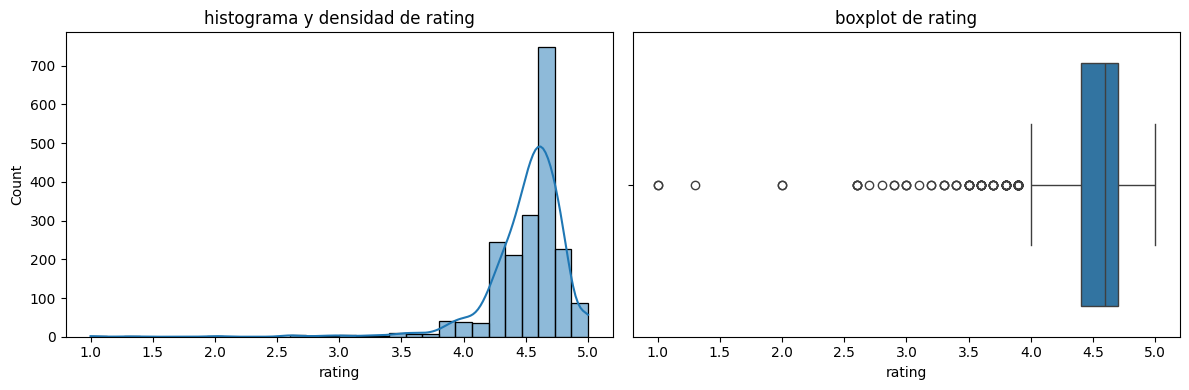


desc de 'reviewCount':
count      1996.000000
mean      10014.972445
std       36569.366678
min           1.000000
25%         191.000000
50%        1229.500000
75%        6820.500000
max      834243.000000
Name: reviewCount, dtype: float64


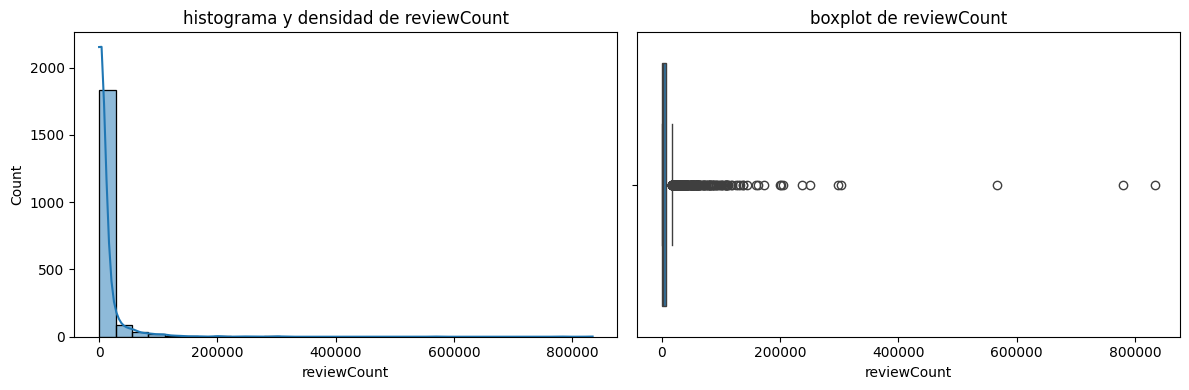


frecuencia de valores en 'category':
category
Clothing, Shoes & Jewelry       544
Sports & Outdoors               291
Automotive                      246
Books                           164
Industrial & Scientific         162
Audible Books & Originals        70
Grocery & Gourmet Food           68
CDs & Vinyl                      64
Kindle Store                     57
Office Products                  45
Health & Household               32
Electronics                      31
Kitchen & Dining                 30
Toys & Games                     28
Home & Kitchen                   27
Musical Instruments              24
Patio, Lawn & Garden             20
Amazon Devices & Accessories     12
Pet Supplies                     11
Movies & TV                      10
Cell Phones & Accessories        10
Baby                              9
Video Games                       8
Tools & Home Improvement          8
Arts, Crafts & Sewing             5
Beauty & Personal Care            5
Computers & Acces

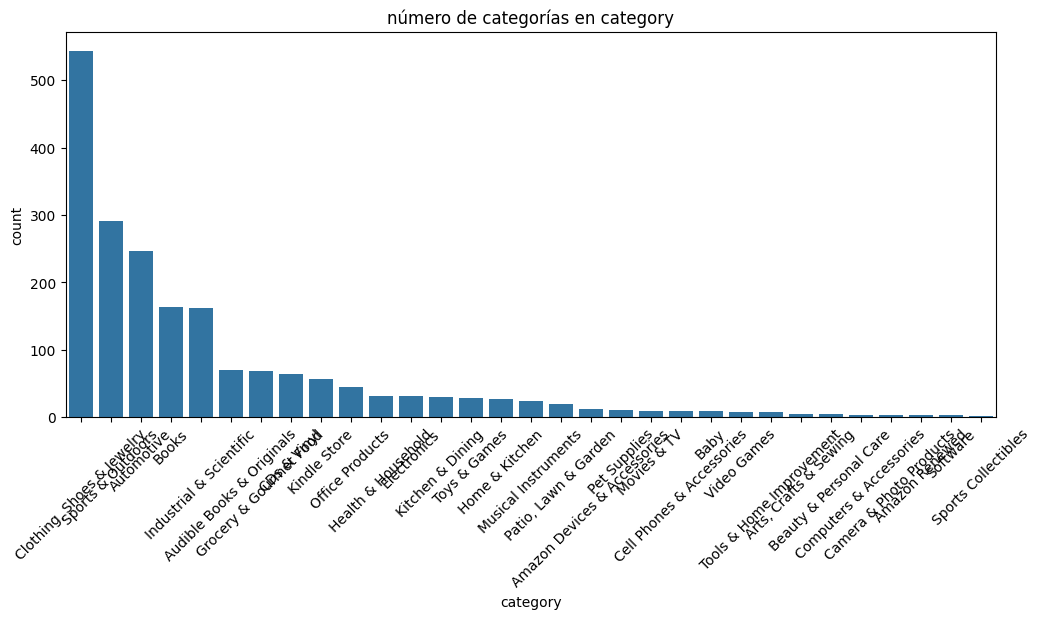


frecuencia de valores en 'brand':
brand
.us               768
Amazon            166
audible logo      122
generic            52
dorman             40
                 ... 
general motors      6
microsoft           6
motorcraft          6
prime-line          6
small parts         4
Name: count, Length: 85, dtype: int64


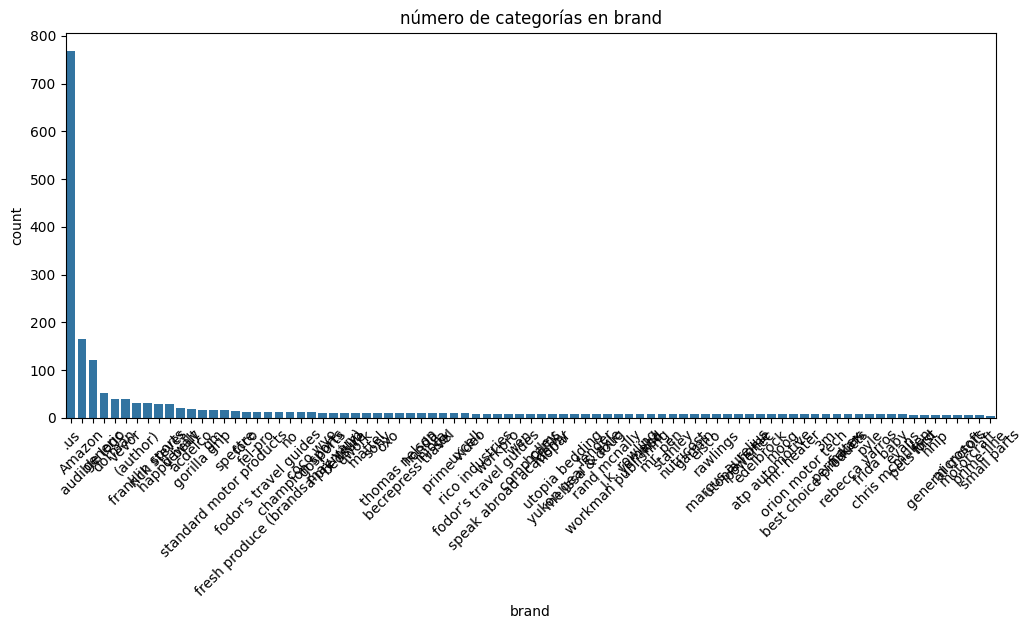


número de valores en 'has_variants':
has_variants
1    1108
0     888
Name: count, dtype: Int64


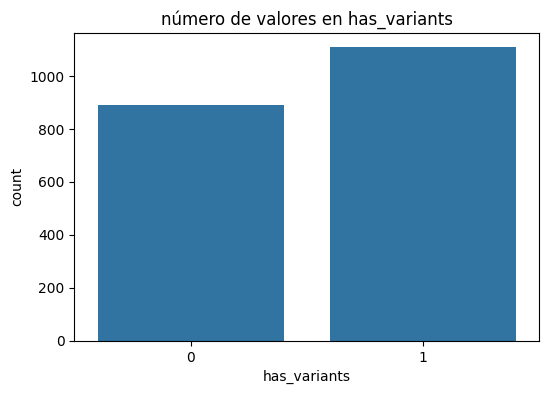

In [79]:
# análisis para rating y reviewCount (numericas)

for col in ['rating', 'reviewCount']:
    print(f"\ndesc de '{col}':")
    print(X_train[col].describe())
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.histplot(X_train[col], kde=True, bins=30) # hist kde
    plt.title(f'histograma y densidad de {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=X_train[col])
    plt.title(f'boxplot de {col}')
    
    plt.tight_layout()
    plt.show()


# análisis para category y brand (categoricas)

for col in ['category', 'brand']:
    print(f"\nfrecuencia de valores en '{col}':")
    print(X_train[col].value_counts())
    
    plt.figure(figsize=(12,5))
    
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index)
    plt.title(f'número de categorías en {col}')
    plt.xticks(rotation=45)
    plt.show()
    

# análisis para has_variants

print("\nnúmero de valores en 'has_variants':")
print(X_train['has_variants'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=X_train['has_variants'])
plt.title('número de valores en has_variants')
plt.show()




# 10. Análisis Bivariante

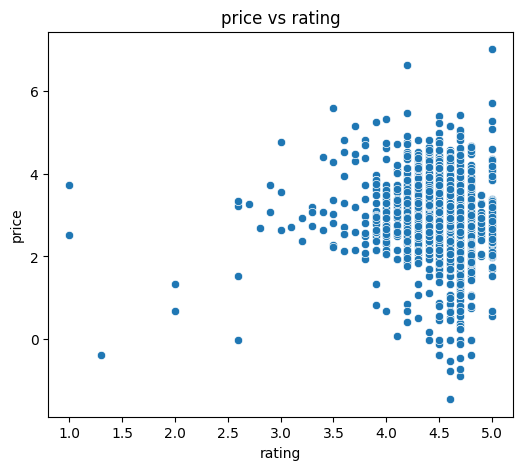

corr pearson: -0.075 (p-valor: 0.001)


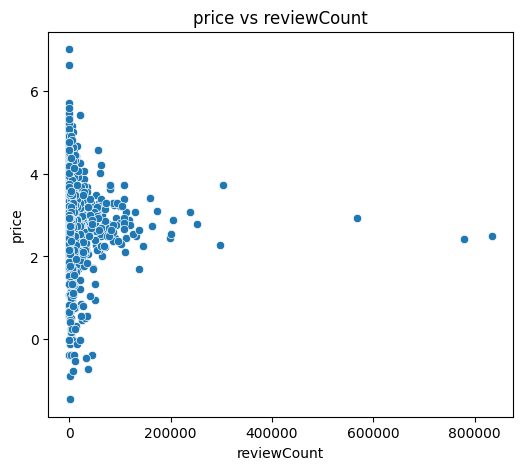

corr pearson: -0.034 (p-valor: 0.131)


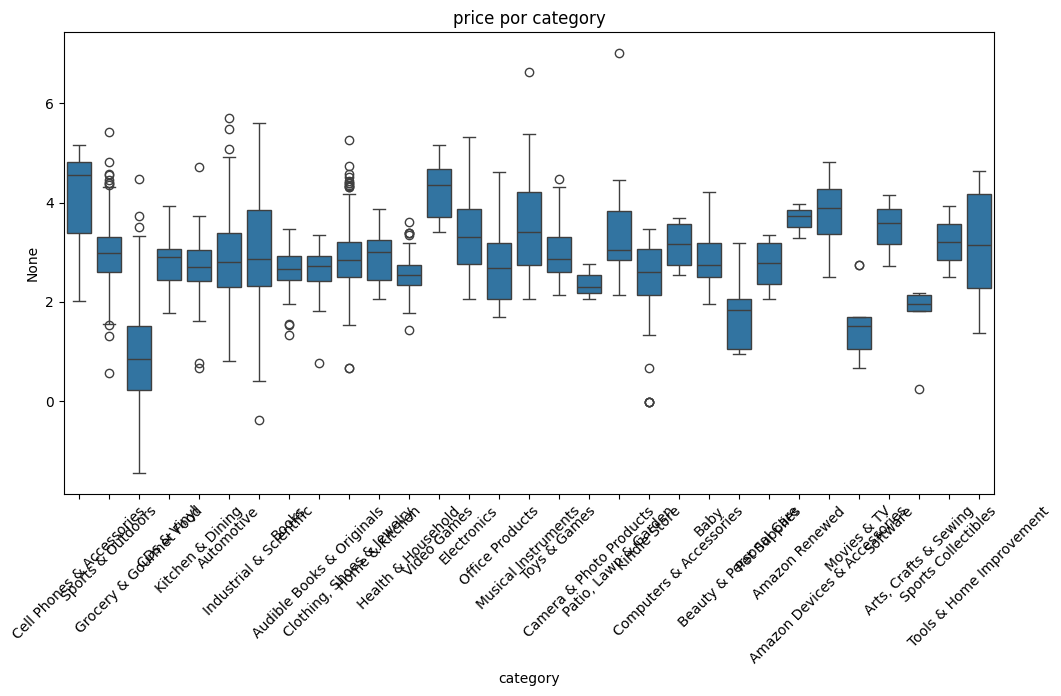

ANOVA p-valor para precio/category: 0.00000


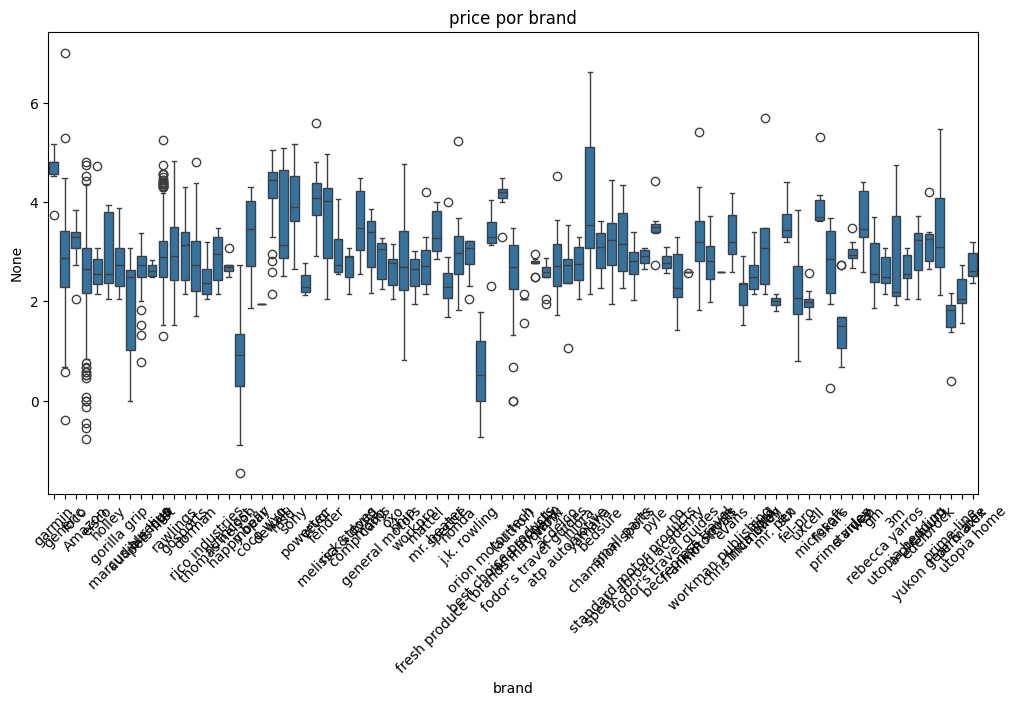

ANOVA p-valor para precio/brand: 0.00000


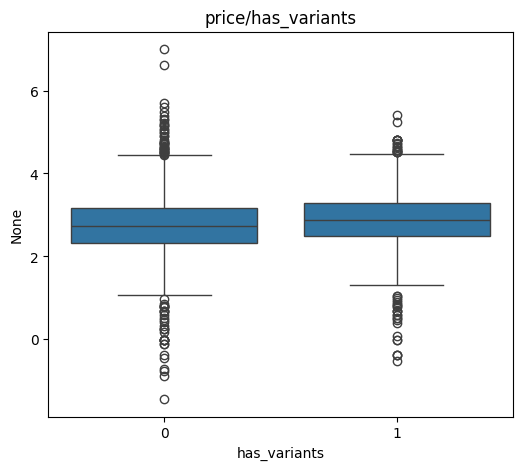

test t para precio/has_variants: t=3.088, p-valor=0.00205


In [80]:
# price vs rating 

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train['rating'], y=y_train)
plt.title('price vs rating')
plt.xlabel('rating')
plt.ylabel('price')
plt.show()

# corr pearson
pearson_corr, p_value = stats.pearsonr(X_train['rating'], y_train)
print(f"corr pearson: {pearson_corr:.3f} (p-valor: {p_value:.3f})")

# price vs reviewCount

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train['reviewCount'], y=y_train)
plt.title('price vs reviewCount')
plt.xlabel('reviewCount')
plt.ylabel('price')
plt.show()

# corr pearson
pearson_corr_rc, p_value_rc = stats.pearsonr(X_train['reviewCount'], y_train)
print(f"corr pearson: {pearson_corr_rc:.3f} (p-valor: {p_value_rc:.3f})")

# price vs category

plt.figure(figsize=(12,6))
sns.boxplot(x=X_train['category'], y=y_train)
plt.title('price por category')
plt.xticks(rotation=45)
plt.show()

# ANOVA
anova_result = stats.f_oneway(*(y_train[X_train['category'] == cat] for cat in X_train['category'].unique()))
print(f"ANOVA p-valor para precio/category: {anova_result.pvalue:.5f}")

# price vs brand

plt.figure(figsize=(12,6))
sns.boxplot(x=X_train['brand'], y=y_train)
plt.title('price por brand')
plt.xticks(rotation=45)
plt.show()

anova_result_bc = stats.f_oneway(*(y_train[X_train['brand'] == cat] for cat in X_train['brand'].unique()))
print(f"ANOVA p-valor para precio/brand: {anova_result_bc.pvalue:.5f}")


# price vs has_variants

plt.figure(figsize=(6,5))
sns.boxplot(x=X_train['has_variants'], y=y_train)
plt.title('price/has_variants')
plt.show()

# Test t de Student para diferencia de medias
grupo_true = y_train[X_train['has_variants'] == True]
grupo_false = y_train[X_train['has_variants'] == False]

t_stat, p_val = stats.ttest_ind(grupo_true, grupo_false, equal_var=False)
print(f"test t para precio/has_variants: t={t_stat:.3f}, p-valor={p_val:.5f}")

# 11. Outliers

In [81]:
Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (y_train < lower_bound) | (y_train > upper_bound)

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

print(f"Total de datos: {len(y_train)}")
print(f"Cantidad de Outliers: {outliers_mask.sum()}")

# veo algunos outliers
print(y_train[outliers_mask].head(10))

Q1: 2.3865849045657175
Q3: 3.2227161226768706
IQR: 0.8361312181111531
Lower bound: 1.1323880773989878
Upper bound: 4.4769129498436
Total de datos: 1996
Cantidad de Outliers: 127
3478     5.159378
3768     0.571855
14717    0.393897
12617    0.959861
15791    4.565763
25748    5.159378
24201    4.561151
14450    0.325972
14896    0.463236
6244     5.281698
dtype: float64


In [82]:
# capar outliers

y_train_capped = y_train.copy()
y_train[y_train < lower_bound] = lower_bound
y_train[y_train > upper_bound] = upper_bound

'''
# Eliminar outliers
X_train_clean = X_train.loc[~outliers_mask]
y_train_clean = y_train.loc[~outliers_mask]
'''

'\n# Eliminar outliers\nX_train_clean = X_train.loc[~outliers_mask]\ny_train_clean = y_train.loc[~outliers_mask]\n'

In [83]:
X_test.columns

Index(['rating', 'reviewCount', 'brand', 'category', 'has_variants'], dtype='object')

In [84]:
# Hago esto porque si no los modelos petan con nulos

# mask es un boolean array para filas sin NaNs en X_test
mask = ~X_test.isna().any(axis=1)

X_test = X_test.loc[mask] # aplico mascara

y_test = y_test[mask] # aplico mascara


In [85]:
print("NaNs en X_train:", X_train.isna().sum().sum())
print("NaNs en X_test:", X_test.isna().sum().sum())

NaNs en X_train: 0
NaNs en X_test: 0


In [86]:
print(X_train.head(5))
X_train.shape

       rating  reviewCount    brand                   category  has_variants
3478      4.6       1431.0   garmin  Cell Phones & Accessories             0
24582     4.3         39.0  generic          Sports & Outdoors             1
24619     4.5      18065.0     foco          Sports & Outdoors             1
12524     4.4          3.0  generic     Grocery & Gourmet Food             0
21789     4.8        104.0   Amazon                CDs & Vinyl             0


(1996, 5)

In [87]:
print(X_test.head(5))
X_test.shape

       rating  reviewCount                    brand  \
19962     4.2         38.0  standard motor products   
24679     4.5        619.0                      .us   
18449     4.6        579.0                      .us   
7127      4.5       1952.0                       3m   
2417      4.6       6464.0                      wen   

                        category  has_variants  
19962                 Automotive             0  
24679          Sports & Outdoors             1  
18449  Clothing, Shoes & Jewelry             1  
7127     Industrial & Scientific             0  
2417     Industrial & Scientific             1  


(685, 5)

In [88]:
print(y_train.head(5))
y_train.shape

3478     4.476913
24582    2.598312
24619    3.182504
12524    3.504163
21789    3.143947
dtype: float64


(1996,)

# 12. Escoger Métrica del Modelo

In [89]:
# Metricas de regresión


X_train = pd.get_dummies(X_train) # Hago one hot encoding de las categoricas
X_test = pd.get_dummies(X_test) # Hago one hot encoding de las categoricas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


lr = LinearRegression()
X = X_train
Y = y_train

lr.fit(X, Y)
preds = lr.predict(X)

print("Score del modelo (R^2):", round(lr.score(X, Y), 4))
print("R^2 score:", round(r2_score(preds, Y), 4))
print("MAE score:", round(mean_absolute_error(preds, Y), 4))
print("MSE score:", round(mean_squared_error(preds, Y), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(preds, Y)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(preds, Y), 4))

Score del modelo (R^2): 0.4186
R^2 score: -0.3886
MAE score: 0.421
MSE score: 0.3034
RMSE score: 0.5508
MAPE score: 16.4675


In [90]:
# entrenar arbol
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test) # prediccion

print("Score del modelo (R^2 - train):", round(tree.score(X_train, y_train), 4))
print("R^2 score (test):", round(r2_score(y_test, y_pred), 4))
print("MAE score:", round(mean_absolute_error(y_test, y_pred), 4))
print("MSE score:", round(mean_squared_error(y_test, y_pred), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

Score del modelo (R^2 - train): 0.9978
R^2 score (test): -0.0475
MAE score: 0.6068
MSE score: 0.6461
RMSE score: 0.8038


In [91]:


# defino modelo
rf = RandomForestRegressor(random_state=42)

# grif para buscar hiperparametros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5, 10]
}

# gridSearch cross validation / 3folds
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, scoring='r2', n_jobs=-1, verbose=1)

# entrenar
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# prediecir con mejor modelo
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("R^2 (train):", round(best_rf.score(X_train, y_train), 4))
print("R^2 (test):", round(r2_score(y_test, y_pred), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))
print("MSE:", round(mean_squared_error(y_test, y_pred), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("MAPE:", round(mean_absolute_percentage_error(y_test, y_pred), 4))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
R^2 (train): 0.3872
R^2 (test): 0.2943
MAE: 0.4886
MSE: 0.4353
RMSE: 0.6597
MAPE: 64.3691


In [92]:
print("NaNs en X_train:", X_train.isna().sum().sum())
print("NaNs en X_test:", X_test.isna().sum().sum())

NaNs en X_train: 0
NaNs en X_test: 0


In [93]:

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Modelo: {name}")
    print("Score del modelo (R^2 - train):", round(model.score(X_train, y_train), 4))
    print("R^2 score (test):", round(r2_score(y_test, y_pred), 4))
    print("MAE score:", round(mean_absolute_error(y_test, y_pred), 4))
    print("MSE score:", round(mean_squared_error(y_test, y_pred), 4))
    print("RMSE score:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
    print("-" * 30)

Modelo: Decision Tree
Score del modelo (R^2 - train): 0.9978
R^2 score (test): -0.0475
MAE score: 0.6068
MSE score: 0.6461
RMSE score: 0.8038
------------------------------
Modelo: Random Forest
Score del modelo (R^2 - train): 0.8978
R^2 score (test): 0.3172
MAE score: 0.4833
MSE score: 0.4211
RMSE score: 0.649
------------------------------
Modelo: Hist Gradient Boosting
Score del modelo (R^2 - train): 0.5266
R^2 score (test): 0.2397
MAE score: 0.5073
MSE score: 0.469
RMSE score: 0.6848
------------------------------
Modelo: Linear Regression
Score del modelo (R^2 - train): 0.4186
R^2 score (test): 0.3821
MAE score: 0.4567
MSE score: 0.3811
RMSE score: 0.6173
------------------------------
Modelo: Ridge Regression
Score del modelo (R^2 - train): 0.4156
R^2 score (test): 0.3787
MAE score: 0.4572
MSE score: 0.3832
RMSE score: 0.619
------------------------------
Modelo: Lasso Regression
Score del modelo (R^2 - train): 0.0013
R^2 score (test): 0.001
MAE score: 0.5691
MSE score: 0.6162
RM

In [94]:
'''
Ajustado outliers


Modelo: Decision Tree
Score del modelo (R^2 - train): 0.9598
R^2 score (test): -1.0356
MAE score: 0.6663
MSE score: 0.6882
RMSE score: 0.8296
------------------------------
Modelo: Random Forest
Score del modelo (R^2 - train): 0.8363
R^2 score (test): -0.101
MAE score: 0.4723
MSE score: 0.3723
RMSE score: 0.6101
------------------------------
Modelo: Hist Gradient Boosting
Score del modelo (R^2 - train): 0.2317
R^2 score (test): 0.0923
MAE score: 0.4303
MSE score: 0.3069
RMSE score: 0.554
------------------------------
Modelo: Linear Regression
Score del modelo (R^2 - train): 0.1578
R^2 score (test): 0.068
MAE score: 0.4362
...
MAE score: 0.4708
MSE score: 0.3513
RMSE score: 0.5927

Eliminando outiers

Modelo: Decision Tree
Score del modelo (R^2 - train): 0.9572
R^2 score (test): -0.9548
MAE score: 0.6471
MSE score: 0.6609
RMSE score: 0.813
------------------------------
Modelo: Random Forest
Score del modelo (R^2 - train): 0.8353
R^2 score (test): -0.1102
MAE score: 0.4766
MSE score: 0.3754
RMSE score: 0.6127
------------------------------
Modelo: Hist Gradient Boosting
Score del modelo (R^2 - train): 0.2219
R^2 score (test): 0.0666
MAE score: 0.4349
MSE score: 0.3156
RMSE score: 0.5618
------------------------------
Modelo: Linear Regression
Score del modelo (R^2 - train): 0.1608
R^2 score (test): 0.0578
MAE score: 0.4371
...
MAE score: 0.4714
MSE score: 0.3524
RMSE score: 0.5936
'''

'\nAjustado outliers\n\n\nModelo: Decision Tree\nScore del modelo (R^2 - train): 0.9598\nR^2 score (test): -1.0356\nMAE score: 0.6663\nMSE score: 0.6882\nRMSE score: 0.8296\n------------------------------\nModelo: Random Forest\nScore del modelo (R^2 - train): 0.8363\nR^2 score (test): -0.101\nMAE score: 0.4723\nMSE score: 0.3723\nRMSE score: 0.6101\n------------------------------\nModelo: Hist Gradient Boosting\nScore del modelo (R^2 - train): 0.2317\nR^2 score (test): 0.0923\nMAE score: 0.4303\nMSE score: 0.3069\nRMSE score: 0.554\n------------------------------\nModelo: Linear Regression\nScore del modelo (R^2 - train): 0.1578\nR^2 score (test): 0.068\nMAE score: 0.4362\n...\nMAE score: 0.4708\nMSE score: 0.3513\nRMSE score: 0.5927\n\nEliminando outiers\n\nModelo: Decision Tree\nScore del modelo (R^2 - train): 0.9572\nR^2 score (test): -0.9548\nMAE score: 0.6471\nMSE score: 0.6609\nRMSE score: 0.813\n------------------------------\nModelo: Random Forest\nScore del modelo (R^2 - trai

In [95]:
param_grid_hist = {
    'max_iter': [100, 200, 300],             # cantidad de arboles
    'max_depth': [3, 5, 7, 10],              # profundidad máxima por árbol
    'learning_rate': [0.01, 0.05, 0.1],      # ritmo de entrenamiento
    'min_samples_leaf': [20, 50, 100],       # min samples por hoja
    'max_leaf_nodes': [15, 31, 63],          # max de hojas por árbol
    'l2_regularization': [0, 1, 5]           # regularizar para evitar overfitting
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 10, 20, 30],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 5, 10],       
    'max_features': ['auto', 'sqrt', 0.5]    # características a tener en cuenta para cada split
}

In [96]:

hgb = HistGradientBoostingRegressor(random_state=42)
random_search_hgb = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_grid_hist,
    n_iter=20,               
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
random_search_hgb.fit(X_train, y_train)

print("Mejores parámetros HistGB:", random_search_hgb.best_params_)
print("Mejor R2 CV:", random_search_hgb.best_score_)

Mejores parámetros HistGB: {'min_samples_leaf': 20, 'max_leaf_nodes': 15, 'max_iter': 300, 'max_depth': 7, 'learning_rate': 0.01, 'l2_regularization': 5}
Mejor R2 CV: 0.20665598504904456


In [97]:


models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        random_state=42,
        min_samples_leaf=20,
        max_leaf_nodes=15,
        max_iter=300,
        max_depth=5,
        learning_rate=0.05,
        l2_regularization=5
    ),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Modelo: {name}")
    print("Score del modelo (R^2 - train):", round(model.score(X_train, y_train), 4))
    print("R^2 score (test):", round(r2_score(y_test, y_pred), 4))
    print("MAE score:", round(mean_absolute_error(y_test, y_pred), 4))
    print("MSE score:", round(mean_squared_error(y_test, y_pred), 4))
    print("RMSE score:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))
    print("-" * 30)

Modelo: Decision Tree
Score del modelo (R^2 - train): 0.9978
R^2 score (test): -0.0475
MAE score: 0.6068
MSE score: 0.6461
RMSE score: 0.8038
------------------------------
Modelo: Random Forest
Score del modelo (R^2 - train): 0.8978
R^2 score (test): 0.3172
MAE score: 0.4833
MSE score: 0.4211
RMSE score: 0.649
------------------------------
Modelo: Hist Gradient Boosting
Score del modelo (R^2 - train): 0.3832
R^2 score (test): 0.2473
MAE score: 0.5016
MSE score: 0.4642
RMSE score: 0.6813
------------------------------
Modelo: Linear Regression
Score del modelo (R^2 - train): 0.4186
R^2 score (test): 0.3821
MAE score: 0.4567
MSE score: 0.3811
RMSE score: 0.6173
------------------------------
Modelo: Ridge Regression
Score del modelo (R^2 - train): 0.4156
R^2 score (test): 0.3787
MAE score: 0.4572
MSE score: 0.3832
RMSE score: 0.619
------------------------------
Modelo: Lasso Regression
Score del modelo (R^2 - train): 0.0013
R^2 score (test): 0.001
MAE score: 0.5691
MSE score: 0.6162
R

# 10. Pipelines

In [98]:
X_train.columns

Index(['rating', 'reviewCount', 'has_variants', 'brand_(author)', 'brand_.us',
       'brand_3m', 'brand_Amazon', 'brand_a-premium', 'brand_acdelco',
       'brand_atp automotive',
       ...
       'category_Musical Instruments', 'category_Office Products',
       'category_Patio, Lawn & Garden', 'category_Pet Supplies',
       'category_Software', 'category_Sports & Outdoors',
       'category_Sports Collectibles', 'category_Tools & Home Improvement',
       'category_Toys & Games', 'category_Video Games'],
      dtype='object', length=119)

In [99]:


# defino numéricas categóricas
num_cols = ['rating', 'reviewCount']
# las categóricas están one-hot encoded y sin nulos asi que no las toco

# imputar mediana en numericas si hay nulos
num_transformer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols)
    ],
    remainder='passthrough'  # deja el resto tal cual
)

# Mejores parámetros HistGB: {'min_samples_leaf': 20, 'max_leaf_nodes': 15, 'max_iter': 300, 'max_depth': 7, 'learning_rate': 0.01, 'l2_regularization': 5}

# defino modelo con mejores parámetros
model = HistGradientBoostingRegressor(
    random_state=42,
    min_samples_leaf=20,
    max_leaf_nodes=15,
    max_iter=300,
    max_depth=7,
    learning_rate=0.01,
    l2_regularization=5
)

# full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# entreno
pipeline.fit(X_train, y_train)

# pred
y_pred = pipeline.predict(X_test)



print(f"R^2 score (train): {pipeline.score(X_train, y_train):.4f}")
print(f"R^2 score (test): {r2_score(y_test, y_pred):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE score: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R^2 score (train): 0.2975
R^2 score (test): 0.2231
MAE score: 0.5070
MSE score: 0.4792
RMSE score: 0.6922


In [100]:




# defino numéricas categóricas
num_cols = ['rating', 'reviewCount']
# las categóricas están one-hot encoded y sin nulos asi que no las toco

# imputar mediana en numericas si hay nulos
num_transformer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols)
    ],
    remainder='passthrough'  # las demás columnas (one-hot) quedan igual
)

# defino el modelo de regresión lineal
model = LinearRegression()

# creo pipeline con preprocesador y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# entreno
pipeline.fit(X_train, y_train)

# predecir
y_pred = pipeline.predict(X_test)




print(f"R^2 score (train): {pipeline.score(X_train, y_train):.4f}")
print(f"R^2 score (test): {r2_score(y_test, y_pred):.4f}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE score: {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R^2 score (train): 0.4186
R^2 score (test): 0.3821
MAE score: 0.4567
MSE score: 0.3811
RMSE score: 0.6173


In [101]:


num_cols = ['rating', 'reviewCount']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols)
    ],
    remainder='passthrough'
)

# defino modelos con sus pipelines
pipelines = {
    'lin_reg': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
}

# hiperparámetros para cada modelo
param_grids = {
    'lin_reg': {},  
    'ridge': {
        'regressor__alpha': np.logspace(-3, 3, 7)
    },
    'lasso': {
        'regressor__alpha': np.logspace(-3, 3, 7)
    },
    'random_forest': {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [3, 5, 7, None],
        'regressor__max_features': ['sqrt', 'log2']
    }
}

# entreno
models_gridsearch = {}
for name, pipeline in pipelines.items():
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    models_gridsearch[name] = grid

# evalúo resultados
results = []
for name, grid in models_gridsearch.items():
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    results.append({
        'Model': name,
        'Train R^2': best_model.score(X_train, y_train),
        'Test R^2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# resultados
df_results = pd.DataFrame(results).sort_values(by='Test R^2', ascending=False)
print(df_results)

           Model  Train R^2  Test R^2       MAE       MSE      RMSE
0        lin_reg   0.418649  0.382124  0.456692  0.381092  0.617327
1          ridge   0.415620  0.378720  0.457241  0.383192  0.619025
2          lasso   0.384960  0.354457  0.464423  0.398156  0.630996
3  random_forest   0.898650  0.317833  0.491620  0.420745  0.648649


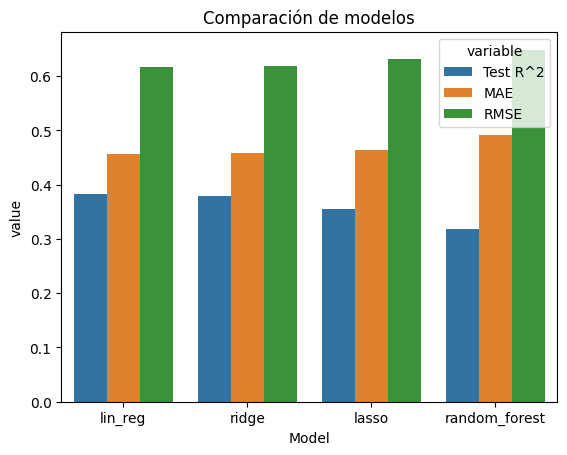

In [102]:
melted = df_results.melt(id_vars='Model', value_vars=['Test R^2', 'MAE', 'RMSE'])
sns.barplot(data=melted, x='Model', y='value', hue='variable')
plt.title('Comparación de modelos')
plt.savefig("../img/comp_modelos.png") 
plt.show()

